In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Input, concatenate
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

# Loading the wind dataset
df = pd.read_csv("C:/Users/onyxe/Desktop/vector-autoregressive-model-wind/T1totalclean.csv", index_col="timestamp", parse_dates=True)
df.head()

#Make last column to power 
df = df[["windspeed","winddirection","PitchAngle","temperature","power"]]

df.head()
#Nan value yerine mean degeri koy
df = df.fillna(df.mean())   

#Power can not be negative, so make all negative values to zero
df.loc[df['power'] < 0, 'power'] = 0

# create two extra columns in raw_data_nm for x,y compnenents of wind direction df['x_com'], df['y_com'] = x_y_component(df['WindDirection'],                                                           df['WindSpeed'])
df.head()

,windspeed,winddirection,PitchAngle,temperature,power
timestamp,,,,,
2019-01-01 00:00:00,5.2,147.600006,-1.8,5.0,180.899994
2019-01-01 00:10:00,5.4,138.600006,-2.1,5.0,213.300003
2019-01-01 00:20:00,5.0,141.500000,-1.7,5.0,164.100006
2019-01-01 00:30:00,3.5,132.000000,0.6,5.0,21.799999
2019-01-01 00:40:00,3.8,136.899994,0.0,5.0,48.299999


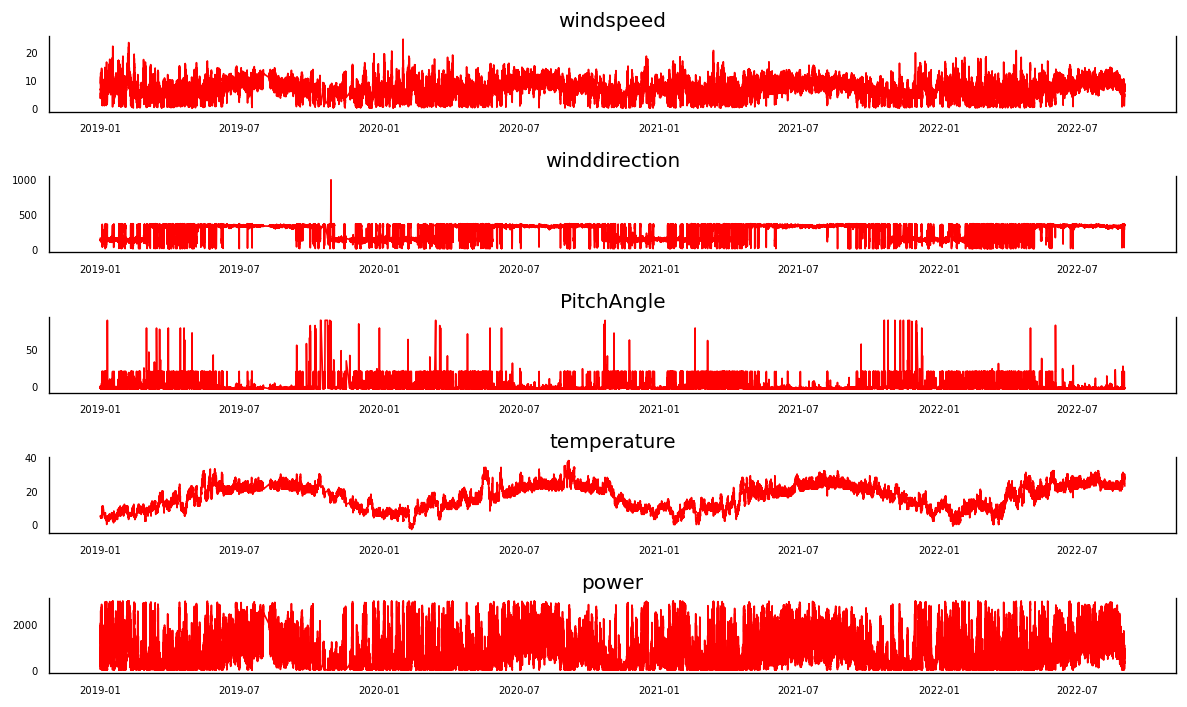

In [36]:
# Plot and visualize
fig, axes = plt.subplots(nrows=5, ncols=1, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [37]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)  

,windspeed_x,winddirection_x,PitchAngle_x,temperature_x,power_x
windspeed_y,1.0,0.0,0.0,0.0,0.0
winddirection_y,0.0,1.0,0.0,0.0,0.0
PitchAngle_y,0.0,0.0,1.0,0.0,0.0
temperature_y,0.0,0.0,0.0,1.0,0.0
power_y,0.0,0.0,0.0,0.0,1.0


In [38]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
windspeed ::  9689.07   > 60.0627   =>   True
winddirection ::  3975.84   > 40.1749   =>   True
PitchAngle ::  2188.92   > 24.2761   =>   True
temperature ::  507.27    > 12.3212   =>   True
power  ::  12.09     > 4.1296    =>   True


In [39]:
nobs = 6
df_train, df_test = df[:-nobs], df[-nobs:]
# Check size 341 rows of train set and only 6 rows of test set
print(df_train.shape)  # (341, 6)
print(df_test.shape)  # (41, 6)

(177339, 5)
(6, 5)


In [40]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")


# ADF Test on each time series column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

C:\Users\onyxe\AppData\Local\Temp\ipykernel_4904\1202651593.py:27: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in df_train.iteritems():


    Augmented Dickey-Fuller Test on "windspeed" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -24.5173
 No. Lags Chosen       = 78
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "winddirection" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -16.9901
 No. Lags Chosen       = 78
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "PitchAngle" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Signifi

In [41]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [42]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

C:\Users\onyxe\AppData\Local\Temp\ipykernel_4904\1957205119.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in df_differenced.iteritems():


    Augmented Dickey-Fuller Test on "windspeed" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -63.5776
 No. Lags Chosen       = 78
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "winddirection" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -62.781
 No. Lags Chosen       = 78
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "PitchAngle" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Signific

In [43]:
# After the first difference, Real Wages (Manufacturing) is still not stationary. It’s critical value is between 5% and 10% significance level.
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [44]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

C:\Users\onyxe\AppData\Local\Temp\ipykernel_4904\1244805990.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in df_differenced.iteritems():


    Augmented Dickey-Fuller Test on "windspeed" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -84.5624
 No. Lags Chosen       = 78
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "winddirection" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -87.2222
 No. Lags Chosen       = 78
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "PitchAngle" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Signifi

In [45]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

C:\Users\onyxe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Lag Order = 1
AIC :  18.38232012406116
BIC :  18.38402634302129
FPE :  96236583.00466149
HQIC:  18.382824939102186 

Lag Order = 2
AIC :  17.572262944650014
BIC :  17.575391028633977
FPE :  42809172.34213638
HQIC:  17.573188443821383 

Lag Order = 3
AIC :  17.105896743495677
BIC :  17.11044670694952
FPE :  26853231.983449806
HQIC:  17.10724293127881 

Lag Order = 4
AIC :  16.80407853455841
BIC :  16.810050391928417
FPE :  19857226.108871233
HQIC:  16.805845415434817 

Lag Order = 5
AIC :  16.594340406766605
BIC :  16.601734172499285
FPE :  16100170.287741493
HQIC:  16.596527985217854 

Lag Order = 6
AIC :  16.435933735569915
BIC :  16.444749424112015
FPE :  13741537.46600639
HQIC:  16.438542016077655 

Lag Order = 7
AIC :  16.312367088078254
BIC :  16.32260471387675
FPE :  12144258.785186779
HQIC:  16.31539607512421 

Lag Order = 8
AIC :  16.21776529141816
BIC :  16.229424868920262
FPE :  11048058.746659873
HQIC:  16.221214989484125 

Lag Order = 9
AIC :  16.142011833859044
BIC :  16.1

In [46]:
# An alternate method to choose the order(p) of the VAR models is to use 
# the model.select_order(maxlags) method. The selected order(p) is the 
# order that gives the lowest ‘AIC’, ‘BIC’, ‘FPE’ and ‘HQIC’ scores.
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,20.15,20.15,5.629e+08,20.15
1,18.38,18.38,9.626e+07,18.38
2,17.57,17.58,4.282e+07,17.57
3,17.11,17.11,2.686e+07,17.11
4,16.80,16.81,1.986e+07,16.81
5,16.59,16.60,1.610e+07,16.60
6,16.44,16.44,1.374e+07,16.44
7,16.31,16.32,1.215e+07,16.32
8,16.22,16.23,1.105e+07,16.22
9,16.14,16.16,1.024e+07,16.15


In [47]:
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 12, Jul, 2023
Time:                     14:16:41
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    16.8101
Nobs:                     177333.    HQIC:                   16.8058
Log likelihood:      -2.74798e+06    FPE:                1.98572e+07
AIC:                      16.8041    Det(Omega_mle):     1.98455e+07
--------------------------------------------------------------------
Results for equation windspeed
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.000000         0.001972            0.000           1.000
L1.windspeed            -0.779204         0.005191         -150.108           0.000
L1.winddirection         0.000581         0.

In [48]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

windspeed : 2.09
winddirection : 2.11
PitchAngle : 2.09
temperature : 2.1
power : 2.09


In [49]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

4


array([[-8.88178420e-16,  8.99994000e-01, -1.00000000e-01,
         0.00000000e+00,  2.75999760e+01],
       [-1.00000000e-01,  4.90002400e+00,  2.00000000e-01,
         0.00000000e+00,  4.80001800e+00],
       [ 3.00000000e-01, -1.40002400e+00, -2.00000000e-01,
         0.00000000e+00,  8.68999940e+01],
       [-9.00000000e-01, -2.60000600e+00,  4.00000000e-01,
         0.00000000e+00, -2.14699982e+02]])

In [50]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,windspeed_2d,winddirection_2d,PitchAngle_2d,temperature_2d,power_2d
timestamp,,,,,
2022-08-31 23:00:00,0.594920,0.092602,0.208119,-0.010794,113.238152
2022-08-31 23:10:00,-0.015963,1.852553,-0.432040,0.011581,8.974625
2022-08-31 23:20:00,-0.042347,-0.098375,0.052874,-0.000190,-4.571543
2022-08-31 23:30:00,-0.019956,-0.848554,0.034831,-0.001105,-5.582776
2022-08-31 23:40:00,-0.078692,-0.066996,0.039454,-0.003810,-22.308396
2022-08-31 23:50:00,0.099385,0.260310,0.099933,0.000313,22.543580


In [51]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['windspeed_forecast', 'winddirection_forecast', 'PitchAngle_forecast', 'temperature_forecast', 'power_forecast']]

,windspeed_forecast,winddirection_forecast,PitchAngle_forecast,temperature_forecast,power_forecast
timestamp,,,,,
2022-08-31 23:00:00,6.694920,335.292584,-1.791881,22.989206,473.938164
2022-08-31 23:10:00,6.673876,336.537726,-1.715801,22.989994,483.350952
2022-08-31 23:20:00,6.610486,337.684493,-1.586847,22.990591,488.192198
2022-08-31 23:30:00,6.527139,337.982707,-1.423062,22.990083,487.450667
2022-08-31 23:40:00,6.365100,338.213925,-1.219823,22.985764,464.400741
2022-08-31 23:50:00,6.302446,338.705452,-0.916652,22.981759,463.894394


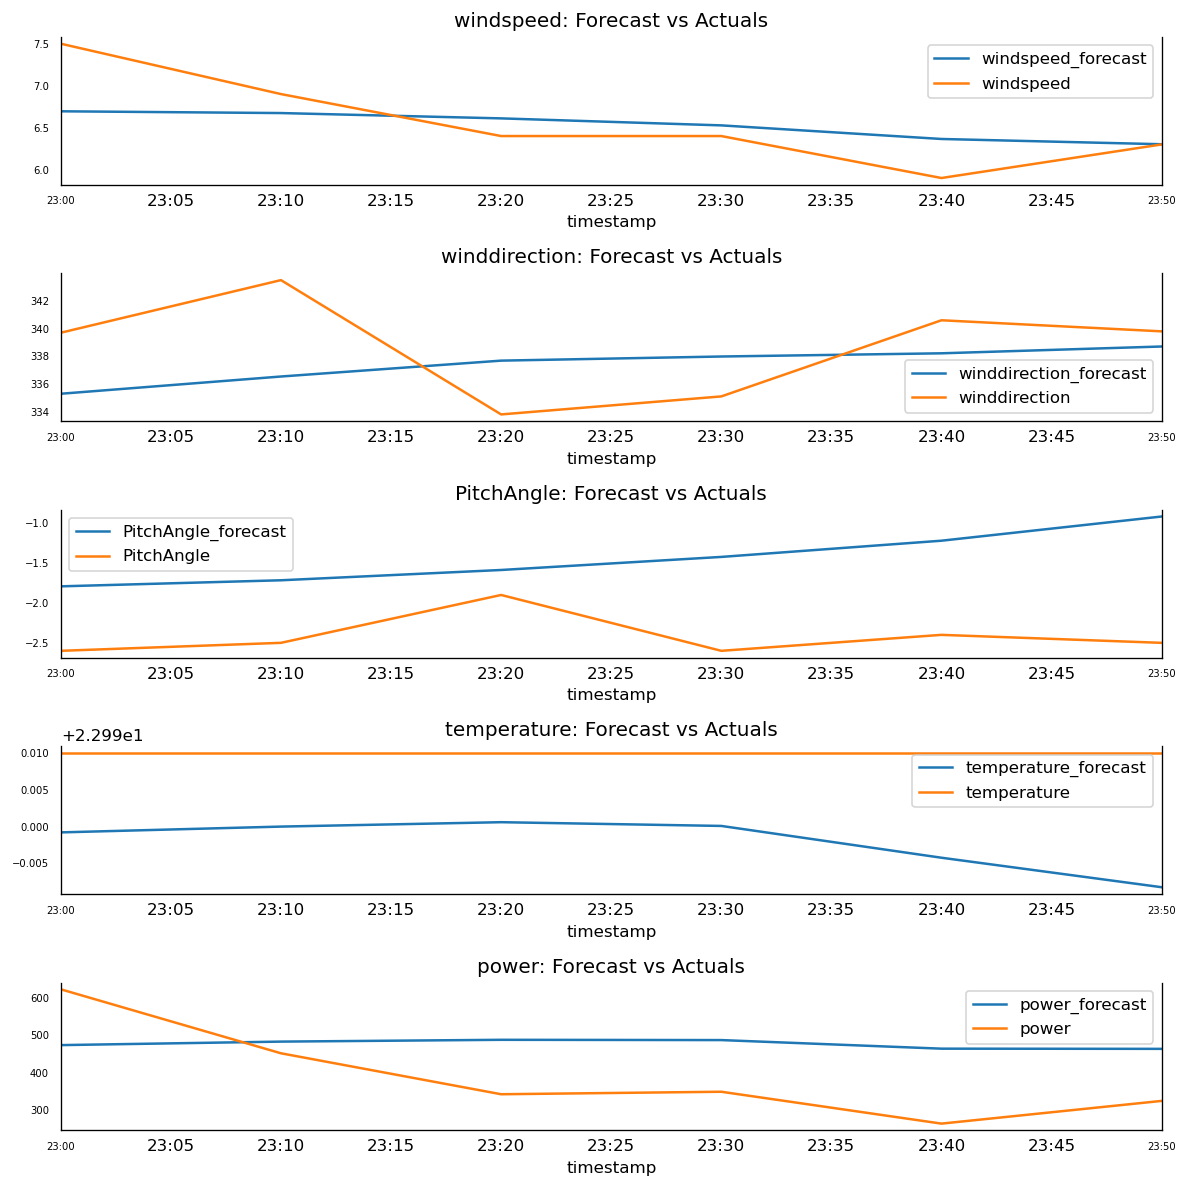

In [56]:
# plot forecast vs. actuals
fig, axes = plt.subplots(nrows=5, ncols=1, dpi=120, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax)
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [54]:
# cal metrics: MAPE, ME, MAE, MPE, RMSE, corr and minmax.
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('\nForecast Accuracy of: power')
accuracy_prod = forecast_accuracy(df_results['power_forecast'].values, df_test['power'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))


Forecast Accuracy of: power
mape :  0.3886
me :  84.5879
mae :  134.5418
mpe :  0.3085
rmse :  143.8343
corr :  0.1644
minmax :  0.2707


C:\Users\onyxe\AppData\Local\Temp\ipykernel_4904\829909821.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\onyxe\AppData\Local\Temp\ipykernel_4904\829909821.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
